<img src="task.jpg" alt="альтернативный текст">

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
import urllib.request

In [2]:
def shape_calculate(input_matrix_shape, out_channels, kernel_size, stride, padding):
    batch_size, channels_count, input_height, input_width = input_matrix_shape
    output_height = (input_height + 2 * padding - (kernel_size - 1) - 1) // stride + 1
    output_width = (input_width + 2 * padding - (kernel_size - 1) - 1) // stride + 1

    return batch_size, out_channels, output_height, output_width

In [3]:
class ABCConv2d(ABC):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride

    def set_kernel(self, kernel):
        self.kernel = kernel

    @abstractmethod
    def __call__(self, input_tensor):
        pass

In [4]:
class Conv2dMatrix(ABCConv2d):
    def __call__(self, input_tensor):
        image_size, out_channels, output_height, output_width = shape_calculate(
            input_tensor.shape,
            self.out_channels,
            self.kernel_size,
            self.stride,
            padding=0)

        output_tensor = np.zeros((image_size, out_channels, output_height, output_width))

        for num_image, image in enumerate(input_tensor):

            for num_filter, filter_ in enumerate(self.kernel):

                for i in range(output_height):
                    for j in range(output_width):
                        current_row = self.stride * i
                        current_column = self.stride * j
                        current_slice = image[:, current_row:current_row + self.kernel_size,
                                        current_column:current_column + self.kernel_size]

                        res = float((current_slice * filter_).sum())

                        output_tensor[num_image, num_filter, i, j] = res

        return output_tensor

In [5]:
class MaxPool2D(ABCConv2d):
    def __call__(self, input_tensor):
        image_size, out_channels, output_height, output_width = shape_calculate(
            input_tensor.shape,
            self.out_channels,
            self.kernel_size,
            self.stride,
            padding=0)

        mat_out = np.zeros((image_size, out_channels, output_height, output_width))

        for num_image, image in enumerate(input_tensor):
            for num_chnl in range(image.shape[0]):

                for i in range(output_height):
                    for j in range(output_width):
                        current_row = self.stride * i
                        current_column = self.stride * j
                        current_slice = image[num_chnl, current_row:current_row + self.kernel_size,
                                        current_column:current_column + self.kernel_size]

                        res = float(current_slice.max())
                        mat_out[num_image, num_chnl, i, j] = res
        return mat_out

In [6]:
class LayerNorm:
    def __call__(self, input_tensor, gamma=1, betta=0, eps=1e-3):
        result = np.zeros(input_tensor.shape)
        for b, batch in enumerate(input_tensor):
            for c, image in enumerate(batch):
                Mu = np.mean(image)
                sigma = np.std(image)
                result[b, c, :, :] = ((image - Mu) / (np.sqrt(sigma ** 2 + eps))) * gamma + betta
        return result

In [7]:
class Relu:
    def __call__(self, input_tensor):
        return np.where(input_tensor > 0, input_tensor, 0)

In [8]:
class Model:
    def __init__(self, stride=1):
        kernel = np.random.randint(-10, 10, 3 * 3 * 3).reshape(3, 3, 3)
        in_channels = kernel.shape[1]
        out_channels = kernel.shape[0]
        kernel_size = kernel.shape[2]

        self.conv2d = Conv2dMatrix(in_channels, out_channels, kernel_size, stride)
        self.conv2d.set_kernel(kernel)
        self.LN = LayerNorm()
        self.relu = Relu()
        self.max_pool = MaxPool2D(out_channels, out_channels, 2, 2)

    def model_forward(self, x):
        x = self.conv2d(x)
        x = self.LN(x)
        x = self.relu(x)
        x = self.max_pool(x)
        e_x = np.exp(x - np.max(x, axis=1))
        return e_x / np.sum(e_x, axis=1)

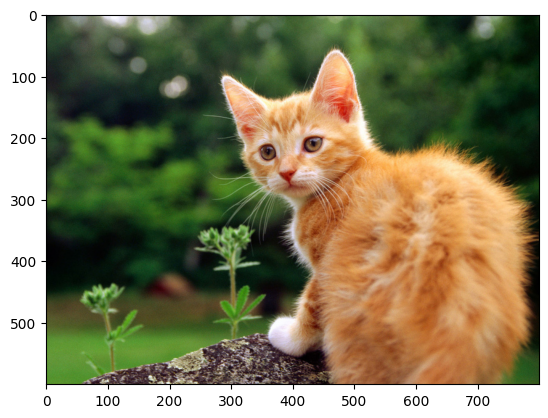

In [9]:
img = cv2.imread('kitty.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [10]:
img = cv2.resize(img, (32, 32)).reshape(1, 3, 32, 32)  # BxCxWxH
Net = Model(stride=1)
out = Net.model_forward(img)
print(f'Model shape: {out.shape}')
print(f'Out: {out}')

Model shape: (1, 3, 15, 15)
Out: [[[[0.68887607 0.404335   0.66772657 0.7353563  0.73584414 0.33854954
    0.51758006 0.4931306  0.7325312  0.58366594 0.5933507  0.62504517
    0.46301243 0.57090057 0.39105715]
   [0.21212414 0.11527095 0.09575165 0.19618945 0.25080956 0.06526147
    0.13270928 0.27199193 0.21897362 0.19630072 0.76675361 0.55884805
    0.60127791 0.59590612 0.47016733]
   [0.44352865 0.28023084 0.21575546 0.45673434 0.21960047 0.20176601
    0.39189597 0.51157941 0.41110531 0.60104949 0.58469592 0.34700605
    0.4124422  0.45347986 0.5087853 ]
   [0.44123706 0.14271733 0.24414539 0.22809291 0.25891996 0.33615216
    0.38792383 0.16447399 0.1270389  0.41457062 0.4125489  0.75529623
    0.77181927 0.72041531 0.60660611]
   [0.15428793 0.19852645 0.28872867 0.56100813 0.17692702 0.17806226
    0.3503513  0.29854184 0.67232425 0.54764984 0.39058366 0.15609713
    0.22088277 0.26544399 0.42897729]
   [0.33838168 0.40846328 0.19221293 0.34631002 0.10601992 0.50433217
    0.3